# **assignment 3**
### by group 9

In [38]:
# imports
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy
from sklearn import random_projection
from scipy.sparse import csr_matrix
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## task
- analyze 2 data sets of your choice using random projections
- study the accuracy (or a score of your choice that makes most sense for your data) (using linear support vector classification) as a function of the number of dimensions / features that survived the random projection
- try to avoid a zig-zag curve below or around the baseline accuracy curve as your final result for both datasets
- at least for one dataset the score is expected to be a smooth-ish curve as a function of the kept number of features
- provide a take-home statement and explain every step
- you will find that data that is embedded in Eucledian spaces (such as
digits) may be more appropriate than data for which Eukledian distances
are not an excellent distance measure

## 1st data set: human perception of swarming

![flocking boids.gif](https://user-images.githubusercontent.com/9216979/45744864-d3d7f400-bbff-11e8-9e3e-0bee1d2f5865.gif)

- the data set consists of informatoon on position and other characteristics (e.g., velocity, separation) of 200 simulated bird androids (boids) in a 2-dimensional space

- the data set collection includes 3 binary labels representing the human perception of flocking, aligning and grouping of the boids

- for the following analysis only the binary classification with regards to flocking is taken into account

- flocking behaviour refers to the way that groups of birds, insects, fish or other animals, move close to each other, being able to move as a group with the same velocity, yet without running into each other

- [source](https://archive.ics.uci.edu/ml/datasets/Swarm+Behaviour)

### import and clean data

In [9]:
# load data
df2 = pd.read_csv("data/Flocking.csv", low_memory=False)

let's take a look into what we are dealing with ...

In [10]:
# display first rows
df2.head()

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Class
0,-1414.14,-535.22,-17.88,-7.23,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.85,0.0,0.00,0.0,0.0,0.00,0.00,29,0,0
1,-1412.93,597.54,-13.55,-5.48,0.00,0.0,0.00,0.00,0.00,0.00,...,-12.09,0.0,0.00,0.0,0.0,0.00,0.00,44,0,0
2,-1407.38,70.72,-14.37,-5.81,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.20,0.0,0.00,0.0,0.0,0.00,0.00,40,0,0
3,-1407,-759.80,-7.59,-1.27,-0.98,-0.2,0.00,0.00,0.91,0.41,...,2.99,-1.0,-0.07,0.0,0.0,-0.52,0.86,3,0,1
4,-1406.36,698.39,-16.54,-6.95,-1.00,0.0,-944.07,-396.62,0.00,0.00,...,-12.61,0.0,-1.00,0.0,0.0,0.00,0.00,13,0,0


let's do some data cleaning ... 

In [11]:
# remove last row in order to handle missing value
df2 = df2.iloc[:-1,:]

# use correct data type for first feature
df2["x1"] = pd.to_numeric(df2["x1"])

now we can split and standardize the features ...

In [12]:
# splitting into data and labels as well as training and test sets
split = train_test_split(df2.iloc[:,:-1],
                         df2.iloc[:,-1],
                         test_size = 0.3,
                         random_state = 22)
(X_train2, X_test2, y_train2, y_test2) = split

# standardization of variables
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

### relationship between $k$ and $\epsilon$

In [13]:
for ep in [0.1,0.15,0.2,0.25,0.3,0.4]:
    min_dim = johnson_lindenstrauss_min_dim(n_samples = X_train2.shape[0],eps = ep)
    print(f"mininmum # of dimensions for episilon = {ep} is {min_dim}")

mininmum # of dimensions for episilon = 0.1 is 8339
mininmum # of dimensions for episilon = 0.15 is 3843
mininmum # of dimensions for episilon = 0.2 is 2245
mininmum # of dimensions for episilon = 0.25 is 1494
mininmum # of dimensions for episilon = 0.3 is 1081
mininmum # of dimensions for episilon = 0.4 is 663


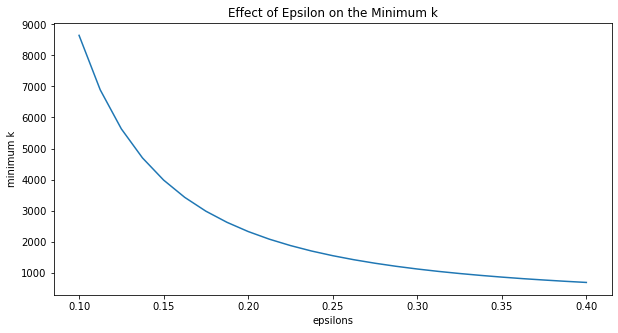

In [14]:
# calculating minimum k for different epsilons
eps = np.linspace(0.1, 0.4, 25)
ks = []
for e in eps:
    ks.append(johnson_lindenstrauss_min_dim(len(df2),eps=e))
    
# plot the relationship
plt.figure(figsize=(10, 5))
plt.plot(eps, ks)
plt.xlabel("epsilons")
plt.ylabel("minimum k")
plt.title("Effect of Epsilon on the Minimum k")
plt.show()

<div class="alert alert-block alert-success">
<b>takeaway:</b> 
    
- we can see that large $\epsilon$ lead to a minimum $k$ of around 1000
    
- as the underlying data has 2401 features ($n=2401$), we know that a mapping from an $n$-dimensional space to a $k$-dimensional space exists depending on which $\epsilon$ is chosen
    
</div>

### model

let's now apply random projections ...

In [15]:
# create baseline accuracy value when using all dimensions
model = LinearSVC(max_iter = 25000)
model.fit(X_train2, y_train2)
baseline2 = metrics.accuracy_score(model.predict(X_test2), y_test2)

In [16]:
# ignore convergence warning
warnings.filterwarnings("ignore")

# loop over the projection sizes k
accuracies2 = []
dims2 = list(range(2, X_test2.shape[1]+1, 50))

for dim in dims2:
    # create random projection
    sp = SparseRandomProjection(n_components = dim)
    X = sp.fit_transform(X_train2)
 
    # train classifier on the sparse random projection, low max_iter to speed up process
    model = LinearSVC(max_iter = 5000)
    model.fit(X, y_train2)
 
    # evaluate model and update accuracies
    test = sp.transform(X_test2)
    accuracies2.append(metrics.accuracy_score(model.predict(test), y_test2))
    
    # progress bar
    print(f"progess: {round(((dims2.index(dim)+1)/len(dims2))*100)}%", end= "\r")   

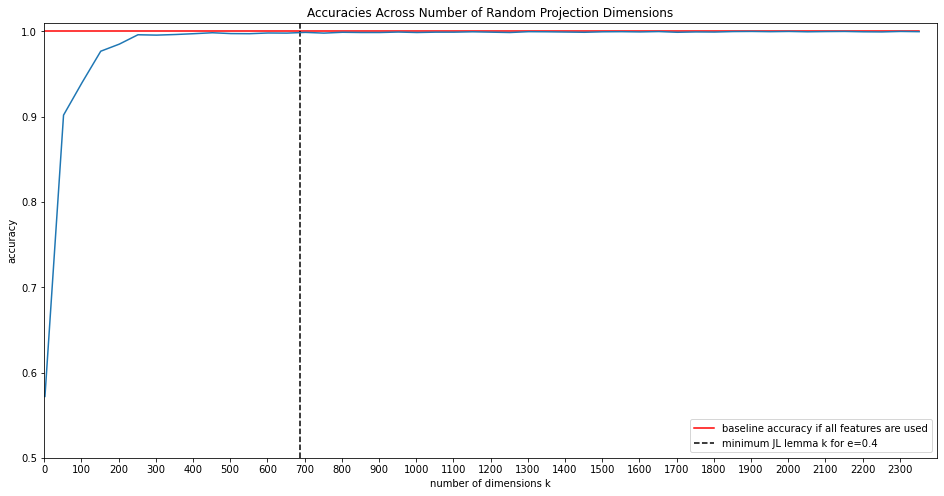

In [17]:
# plot the relationship
plt.figure(figsize=(16, 8))
plt.xlabel("number of dimensions k")
plt.ylabel("accuracy")
plt.xlim([2, X_test2.shape[1]])
plt.xticks(np.arange(0, max(dims2)+1, 100))
plt.ylim([0.5, 1.01]) 
plt.plot(dims2, [baseline2] * len(accuracies2), color = "r", label = "baseline accuracy if all features are used")
plt.axvline(x = johnson_lindenstrauss_min_dim(len(df2),eps=0.4), color = "k", linestyle = "dashed", label = "minimum JL lemma k for e=0.4")
plt.plot(dims2, accuracies2)
plt.title("Accuracies Across Number of Random Projection Dimensions")
plt.legend(bbox_to_anchor=(1,0.1))
plt.show()

<div class="alert alert-block alert-success">
<b>takeaway:</b> 
    
- we can see that using less than 100 dimensions results in relatively low accuracies

- however, way before (in terms of less dimensions used) the minimum $k$ defined by the Johnson-Lindenstrauss lemma, accuracies close to 100% are yielded
    
</div>

### projection efficency: compare Gaussian and sparse projections

In [20]:
# select some pairs of items
n = 2000
randpairs = np.random.randint(X_train2.shape[0],size=(n,2))
print(randpairs)

[[ 3775 15078]
 [   45 16193]
 [12961  8581]
 ...
 [ 2633  2554]
 [ 9211 13607]
 [ 5485 14956]]


now we can compute the distances ...

In [21]:
# define a distance measure between two vectors
def dist(v1,v2):
    return np.linalg.norm(v1-v2)
v1 = np.array([9,10])
v2 = np.array([3,2])
print(dist(v1,v2))

10.0


In [23]:
# distance in the original dimension
dist_original = np.zeros(n)
i =0
total_time = 0.0

for pair in randpairs:
    tick = time.time()
    v2 = X_train2[pair[1]]
    v1 = X_train2[pair[0]]
    dist_original[i] = dist(v1,v2)
    tock = time.time()
           
    total_time = total_time+tock-tick
    i +=1
                      
print(f"total time: {round(total_time, 2)}s")

total time: 0.14s


In [26]:
transformer_sparse = random_projection.SparseRandomProjection(eps=0.4)
transformer_gaussian = random_projection.GaussianRandomProjection(eps=0.4)
transformed_sparse = transformer_sparse.fit_transform(X_train2)
transformed_gaussian = transformer_gaussian.fit_transform(X_train2)
# distance in the reduced dimension
dist_reduced_sparse = np.zeros(n)
dist_reduced_gaussian = np.zeros(n)

total_time_sparse = 0.0
total_time_gaussian = 0.0

i =0
for pair in randpairs:
    tick = time.time()
    v1 = transformed_sparse[pair[0]]
    v2 = transformed_sparse[pair[1]]
    dist_reduced_sparse[i] = dist(v1,v2)
    tock = time.time()
    total_time_sparse = total_time_sparse+tock-tick
    i +=1
    
i =0
for pair in randpairs:
    tick = time.time()
    v1 = transformed_gaussian[pair[0]]
    v2 = transformed_gaussian[pair[1]]
    dist_reduced_gaussian[i] = dist(v1,v2)
    tock = time.time()
    total_time_gaussian = total_time_gaussian+tock-tick
    i +=1
           
           
print(f"total time sparse: {round(total_time_sparse, 2)}s")
print(f"total time Gaussian: {round(total_time_gaussian, 2)}s")

total time sparse: 0.06s
total time Gaussian: 0.01s


In [33]:
# how close are we after reducing dimension?
error_sparse = dist_original - dist_reduced_sparse
error_gaussian = dist_original - dist_reduced_gaussian

#Sparse
nz = []
for i in range(len(error_sparse)):
    if (dist_original[i] !=0):
        nz.append(np.abs(error_sparse[i]/dist_original[i]))
        
nz_error = np.array(nz)
print(f"sparse mean absolute epsilon: {round(np.mean(nz_error), 3)}")
print(f"sparse max epsilon: {round(np.max(nz_error), 3)}")

#Gaussian
nz = []
for i in range(len(error_gaussian)):
    if (dist_original[i] !=0):
        nz.append(np.abs(error_gaussian[i]/dist_original[i]))
        
nz_error = np.array(nz)
print(f"Gaussian mean absolute epsilon: {round(np.mean(nz_error), 3)}")
print(f"Gaussian max epsilon: {round(np.max(nz_error), 3)}")

sparse mean absolute epsilon: 0.022
sparse max epsilon: 0.144
Gaussian mean absolute epsilon: 0.026
Gaussian max epsilon: 0.11


<div class="alert alert-block alert-success">
<b>takeaway:</b>   
    
- Gaussian random projections perform slightly better than sparse random projections in terms of distortion ($\epsilon$)
    
</div>

## 2nd data set: human activitiy recognition using smartphones

![human activity.gif](https://i.pinimg.com/originals/a7/78/19/a778193d04758b169fca966fe0655645.gif)

- the experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years

- each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist 


- using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz 


- the experiments have been video-recorded to label the data manually 


- the obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data


- [source](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones)

### import and clean data

In [34]:
# load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


let's take a look at the data's dimensionality ...

In [36]:
# display data shape
train.shape

(7352, 563)

In [37]:
# check balance of the data
train_outcome = pd.crosstab(index=train["Activity"], columns="count")
train_outcome

col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


<div class="alert alert-block alert-success">
<b>takeaway:</b>   
    
- as we can see the data is quite balanced across its different labels
    
</div>

let's do some data preparation ... 

In [39]:
# data wrangling
X_train = pd.DataFrame(train.drop(['Activity','subject'],axis=1))
y_train_label = train.Activity.values.astype(object)
X_test = pd.DataFrame(test.drop(['Activity','subject'],axis=1))
y_test_label = test.Activity.values.astype(object)

# labelEncoding -y label
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train_label)
y_train = encoder.transform(y_train_label)
encoder.fit(y_test_label)
y_test = encoder.transform(y_test_label)

# scaling the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### relationship between $k$ and $\epsilon$

In [40]:
svm_model = svm.SVC(C = 100, gamma = 0.01,kernel = 'rbf')
svm_model.fit(X_train_scaled, y_train)
baseline = metrics.accuracy_score(svm_model.predict(X_test_scaled), y_test)

In [42]:
for ep in [0.1,0.15,0.2,0.25,0.3,0.4,0.49]:
    min_dim = johnson_lindenstrauss_min_dim(n_samples = X_train_scaled.shape[0],eps = ep)
    print(f"mininmum # of dimensions for episilon = {ep} is {min_dim}")

mininmum # of dimensions for episilon = 0.1 is 7630
mininmum # of dimensions for episilon = 0.15 is 3517
mininmum # of dimensions for episilon = 0.2 is 2054
mininmum # of dimensions for episilon = 0.25 is 1367
mininmum # of dimensions for episilon = 0.3 is 989
mininmum # of dimensions for episilon = 0.4 is 607
mininmum # of dimensions for episilon = 0.49 is 440


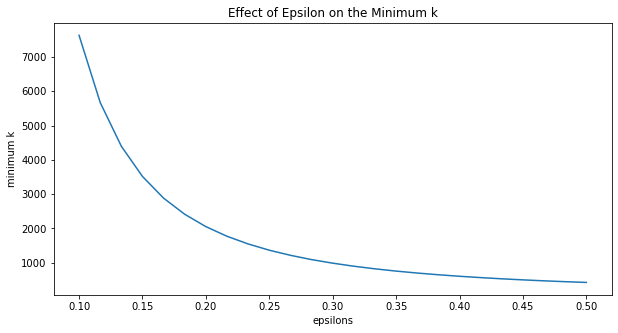

In [43]:
eps = np.linspace(0.1, 0.5, 25)
ks = []
for e in eps:
    ks.append(johnson_lindenstrauss_min_dim(X_train_scaled.shape[0],eps=e))
    
# plot the relationship
plt.figure(figsize=(10, 5))
plt.plot(eps, ks)
plt.xlabel("epsilons")
plt.ylabel("minimum k")
plt.title("Effect of Epsilon on the Minimum k")
plt.show()

<div class="alert alert-block alert-success">
<b>takeaway:</b>   
    
- for a relatively large $\epsilon = 0.4$, $k = 607$ which is still beyond the total number of feature number which is $n = 561$

</div>

### model

let's now apply random projections ...

In [59]:
# loop over the projection sizes k
accuracies = []
dims = np.int32(np.linspace(30, 560, 20))
for dim in dims:
    # create random projection
    sp = SparseRandomProjection(n_components = dim)
    X = sp.fit_transform(X_train_scaled)
 
    # train classifier
    svm_model = svm.SVC(C = 100, gamma = 0.01,kernel = 'rbf')
    svm_model.fit(X, y_train)
 
    # evaluate model and update accuracies
    test = sp.transform(X_test_scaled)
    accuracies.append(metrics.accuracy_score(svm_model.predict(test), y_test))
    
    # progress bar
    print(f"progess: {round(((np.where(dims==dim)[0][0])/len(dims))*100)}%", end= "\r") 

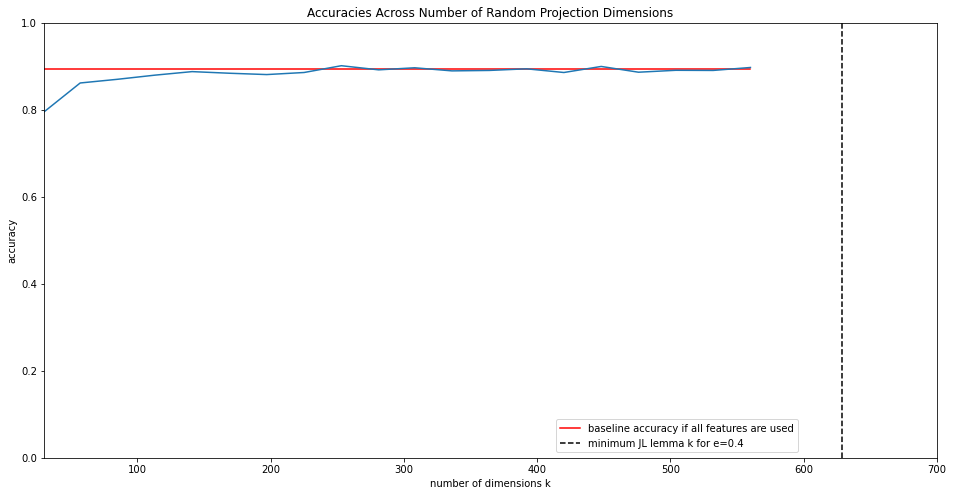

In [68]:
# plot the relationship 
plt.figure(figsize=(16, 8))
plt.xlabel("number of dimensions k")
plt.ylabel("accuracy")
plt.xlim([30, 700])
plt.ylim([0, 1])
plt.title("Accuracies Across Number of Random Projection Dimensions") 
plt.plot(dims, [baseline] * len(accuracies), color = "r", label = "baseline accuracy if all features are used")
plt.axvline(x = johnson_lindenstrauss_min_dim(len(X_train)+len(X_test),eps=0.4), color = "k", linestyle = "dashed", label = "minimum JL lemma k for e=0.4")
plt.plot(dims, accuracies)
plt.legend(bbox_to_anchor=(0.85,0.1))
plt.show()

<div class="alert alert-block alert-success">
<b>takeaway:</b>   
    
- from the plot we can see that using around 200 features the model can reach the accuracy level of the baseline model
    
- this number of dimensions is much less than the minimum $k$ calculation yieled from the Johnson-Lindenstrauss lemma when using $\epsilon = 0.4$ for example which is even out of the rannge of possible dimensions

</div>

### projection efficency: compare Gaussian and sparse projections

In [69]:
# select some pairs of items
n = 2000
randpairs = np.random.randint(X_train_scaled.shape[0],size=(n,2))
print(randpairs)

[[6478 6650]
 [3936 3243]
 [6186  632]
 ...
 [3623 2222]
 [3033 3637]
 [ 498 1190]]


now we can compute the distances ...

In [70]:
# define a distance measure between two vectors
def dist(v1,v2):
    return np.linalg.norm(v1-v2)
v1 = np.array([9,10])
v2 = np.array([3,2])
print(dist(v1,v2))

10.0


In [71]:
# distance in the original dimension
# untransformed_matrix = np.asmatrix(X_train_scaled)
dist_original = np.zeros(n)
i =0
total_time = 0.0

for pair in randpairs:
    tick = time.time()
    v2 = X_train_scaled[pair[1]]
    v1 = X_train_scaled[pair[0]]
    dist_original[i] = dist(v1,v2)
    tock = time.time()
           
    total_time = total_time+tock-tick
    i +=1
              
print(f"total time: {round(total_time, 2)}s")

total time: 0.04s


In [72]:
transformer_sparse = random_projection.SparseRandomProjection(eps=0.5)
transformer_gaussian = random_projection.GaussianRandomProjection(eps=0.5)
transformed_sparse = transformer_sparse.fit_transform(X_train_scaled)
transformed_gaussian = transformer_gaussian.fit_transform(X_train_scaled)
# distance in the reduced dimension
dist_reduced_sparse = np.zeros(n)
dist_reduced_gaussian = np.zeros(n)

total_time_sparse = 0.0
total_time_gaussian = 0.0

i =0
for pair in randpairs:
    tick = time.time()
    v1 = transformed_sparse[pair[0]]
    v2 = transformed_sparse[pair[1]]
    dist_reduced_sparse[i] = dist(v1,v2)
    tock = time.time()
    total_time_sparse = total_time_sparse+tock-tick
    i +=1
    
i =0
for pair in randpairs:
    tick = time.time()
    v1 = transformed_gaussian[pair[0]]
    v2 = transformed_gaussian[pair[1]]
    dist_reduced_gaussian[i] = dist(v1,v2)
    tock = time.time()
    total_time_gaussian = total_time_gaussian+tock-tick
    i +=1
           
           
print(f"total time sparse: {round(total_time_sparse, 2)}s")
print(f"total time Gaussian: {round(total_time_gaussian, 2)}s")

total time sparse: 0.04s
total time Gaussian: 0.02s


In [73]:
# how close are we after reducing dimension?
error_sparse = dist_original - dist_reduced_sparse
error_gaussian = dist_original - dist_reduced_gaussian

#Sparse
nz = []
for i in range(len(error_sparse)):
    if (dist_original[i] !=0):
        nz.append(np.abs(error_sparse[i]/dist_original[i]))
        
nz_error = np.array(nz)
print(f"sparse mean absolute epsilon: {round(np.mean(nz_error), 3)}")
print(f"sparse max epsilon: {round(np.max(nz_error), 3)}")

#Gaussian
nz = []
for i in range(len(error_gaussian)):
    if (dist_original[i] !=0):
        nz.append(np.abs(error_gaussian[i]/dist_original[i]))
        
nz_error = np.array(nz)
print(f"Gaussian mean absolute epsilon: {round(np.mean(nz_error), 3)}")
print(f"Gaussian max epsilon: {round(np.max(nz_error), 3)}")

sparse mean absolute epsilon: 0.029
sparse max epsilon: 0.144
Gaussian mean absolute epsilon: 0.023
Gaussian max epsilon: 0.131


<div class="alert alert-block alert-success">
<b>takeaway:</b>   
    
- Gaussian random projections perform slightly better than sparse random projections in terms of distortion ($\epsilon$)

</div>